## The full Image Analysis Workflow

In this notebook, we will build a complete, end-to-end image analysis pipeline. We'll start with a complex, multi-channel image, learn how to load, inspect and process it, extract quantitative data, and finally, automate the entire workflow to run on a batch of images.

Workflow:
1. Image Handling: Loading multi-dimensional data, inspecting it, and slicing out regions of interest.
2. Processing workflow:
    - Pre-processing: Cleaning up image noise with filters.
    - Segmentation & post-processing: Finding objects with thresholding and cleaning them with morphological operations.
4. Measurement & Analysis: Turning segmented objects into a table of data for plotting and statistical testing.
5. Automation: Automationg processing and scaling the analysis from one image to many.

---
---
### Lesson 1: Load image data and metadata

When working with microscopy or scientific images, the first step is to **load the image** and explore its **metadata**. Understanding the file type and metadata is crucial for processing, analyzing, and storing images correctly.

**Common Bioimage file types**

In microscopy and scientific imaging, images can come in a wide range of **file formats**, each with different capabilities. 


| File Type      | Typical Use Case / Notes                                                      | Bit Depth |
|-------------|------------------------------------------------------------|--------------|
| **TIFF / TIF** | Standard in microscopy; supports multi-page images (z-stacks, time-lapse)   | 8–32      |
| **OME-TIFF (.ome.tif)** | Open Microscopy Environment format; stores multi-channel, multi-dimensional images with metadata | 8–32      |
| **JPEG / JPG** | Compressed (lossy) images, often for visualization rather than analysis               | 8         |
| **PNG**        | Lossless 8-bit/16-bit images; supports transparency                          | 8–16      |
| **Zarr (.zarr)**| Chunked, compressed storage for very large multidimensional datasets         | 8–32      |
| **OME-Zarr (.ome.zarr)**| Zarr with metadata         | 8–32      |
| **Proprietary formats** (e.g., `.czi` Zeiss, `.lif` Leica, `.nd2` Nikon) | Often contain full acquisition metadata but might require specialized readers | Varies    |

**Example Generic reading libraries**
- `skimage.io` (from *scikit-image*), `imageio`,  `tifffile`, `PIL.Image` (from *Pillow*), `AICSImageIO.AICSImage` x `BioIO` (*AICSImageIO* has been merged into the new *bioio* ecosystem and is no longer actively developed)

**Example Specialized format reading libraries**
-  `czifile`, `readlif`, `nd2`, `nd2reader`

**Key Points**

- **Images are arrays**: Whatever the format, libraries usually convert data to a **NumPy array** (or Dask array for Zarr).  
- **Metadata** are additional information: Pixel size, physical units, channel names, acquisition settings... — *not all libraries can read metadata*, *not all file-formats have stored matadata*.  
- **Large datasets**: Zarr or HDF5 formats are useful when images don’t fit in memory.  
- **Proprietary formats**: Often require **specialized libraries**; trying to open with a generic library may fail or lose metadata.


In [ ]:
# Remember, first we need to import packages
import imageio.v3 as iio
import numpy as np


# Define a path to image
image_location = r'../data/mitosis.tif'

# Read image metadata (if available)
metadata = iio.immeta(image_location)
print(metadata)

# for key,value in metadata.items():
#     print(f'{key}: \t {value}') # \t is for tab; \n for newline

In [ ]:
# Note about file paths

# Absolute path: full address on the filesystem
absolute_path = "C:/Users/Username/Documents/demo_cells_image.tif"
print("Absolute path:", absolute_path)

# Relative path: relative to where your Python script / notebook is running
# Special relative markers:
#   .  = current directory
#   .. = parent directory (one level up)
relative_path = "../data/demo_cells_image.tif"
print("Relative path:", relative_path)

# Raw string (r"..."): avoids interpreting backslashes as escape sequences
raw_path = r"C:\Users\Username\Documents\demo_cells_image.tif"
print("Raw string path:", raw_path)

# We will discuss more about dedicated libraries during batch processing

In [ ]:
# Read image data
image_stack = iio.imread(image_location)

# Inspect image dimensions
print("The full data is a NumPy array with the following properties:")
print(f"Data type: {image_stack.dtype}")
print(f"Dimensions: {image_stack.ndim}")
print(f"Shape: {image_stack.shape}") 

In [ ]:
# Plot single slice
import matplotlib.pyplot as plt

single_slice_ch1 = image_stack[0,2,0,:,:]
single_slice_ch2 = image_stack[0,2,1,:,:]


fig, ax = plt.subplots(1,2)

ax[0].imshow(single_slice_ch1, cmap='gray')
ax[0].set_title("Channel 0")
ax[0].axis('off')

ax[1].imshow(single_slice_ch2, cmap='gray')
ax[1].set_title("Channel 1")
ax[1].axis('off')
plt.show()

In [ ]:
# Browse a stack
import stackview # Interactive image stack viewing in jupyter notebooks
print(stackview.__version__)

stackview.slice(image_stack) # we need version > 0.10 to use this


In [ ]:
# Can be customized a bit

channels = [image_stack[:,:,0,:,:], image_stack[:,:,1,:,:]]
colormaps = ["pure_green", "pure_magenta"] 

stackview.switch(images=channels, colormap=colormaps, toggleable=True)

#### Inspect intensity data

It is often useful to explore the distribution of pixel intensities before performing any further analysis. 

This can helps us identify:
- Background vs. foreground signal
- Differences between channels
- Outliers or artifacts

In [ ]:
# stackview.insight() function provides a quick overview of the intensity distribution
# but it does so for the whole array
stackview.insight(image_stack)

If we want more control over plotting or calculating statistics, we can flatten the multi-dimensional arrays of each channel using function `ravel()` 

In [ ]:
# plot histogram per channel

ch0_data = image_stack[:, :, 0, :, :].ravel()   # Flatten everything 
ch1_data = image_stack[:, :, 1, :, :].ravel()

plt.figure(figsize=(8, 5))
plt.hist(ch0_data, bins=100, alpha=0.5, label="Channel 0")
plt.hist(ch1_data, bins=100, alpha=0.5, label="Channel 1")
#plt.xlim(1000, 10000)
plt.legend()
plt.show()

In [ ]:
# Compute and print basic descriptive statistics for each channel:
print("Channel 0: min =", ch0_data.min(), ", max =", ch0_data.max(),
      ", mean =", ch0_data.mean(), ", std =", ch0_data.std())

print("Channel 1: min =", ch1_data.min(), ", max =", ch1_data.max(),
      ", mean =", ch1_data.mean(), ", std =", ch1_data.std())


#### Image transformations

In [ ]:
# Lets read a new image

image = iio.imread('../data/nuclei_stack1.tif')

print(image.shape)

stackview.slice(image)

In [ ]:
# Image cropping
# Can be done simply by slicing array

crop_area1 = image[:,520:,420:]
print(crop_area1.shape)

stackview.slice(crop_area1, zoom_factor=3)

#### Projections

Collapses a stack along an axis to reduce dimensions.

Common projections include:
- **Maximum intensity projection (MIP)**: For each pixel, take the highest intensity across slices. 
- **Minimum intensity projection**: Opposite of min
- **Average (mean) projection**: Computes the mean intensity at each pixel. 
- **Sum projection**: Sums intensities across slices.

In [ ]:
# Projections
# We can collapse one axis (e.g., z-axis in a 3D stack) using functions (sum, mean, max, min, ...)

# Examples - for convenience we will put it to a dictionary
projections = {
    "Max": np.max(image, axis=0),
    "Min": np.min(image, axis=0),
    "Mean": np.mean(image, axis=0),
    "Sum": np.sum(image, axis=0),
}

fig, axes = plt.subplots(1, len(projections), figsize=(20, 5))
for index, ax in enumerate(axes):
    ax.imshow(list(projections.values())[index], cmap='gray') # set vmax to unify colorscale
    ax.set_title(f"{list(projections.keys())[index]} Projection")
    ax.axis('off')
plt.show()

#### Geometric transformations

In [ ]:
# Transformation module
from skimage import transform

# Rotation
max_proj = projections['Max']
rotated_90 = np.rot90(max_proj, k=1) # either use numpy for 90degrees multiples
rotated_45 = transform.rotate(max_proj, angle=45, resize=False) # or skimage transform functions (allows interpolation)

# Rescale
down_sized = transform.rescale(max_proj, scale=0.5, anti_aliasing=True)

images_list = [max_proj, rotated_90, rotated_45, down_sized]
titles_list = ['Untransformed', 'Rotated 90', 'Rotated 45', 'Down-scaled 2x']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for index, ax in enumerate(axes):
    ax.imshow(images_list[index], cmap='gray')
    ax.set_title(f'{titles_list[index]}, {images_list[index].shape}')
    ax.axis('off')
plt.show()



---
---

### Lesson 2: Processing workflow

#### Pre-processing

**Image Filtering**

A filter is a mathematical operation applied to an image to modify or extract information from it. 

Filters are used to:

- Reduce noise (smoothing) - (Gaussian, Median)
- Highlight edges or boundaries (edge detection) - (Sobel)
- Enhance contrast or features
- Extract patterns or textures

Most filters are implemented using a **kernel** (not jupyter kernel).
- A kernel is a small array of numbers that defines how neighboring pixels are combined.
- The kernel is slid across the image, and for each position, a new pixel value is computed based on the neighborhood defined by the kernel.
- This operation may be:
    - Convolution: a weighted sum of neighbors
    - Rank filter: e.g., median, maximum, minimum
    - Other neighborhood operations: e.g., morphological filters like dilation/erosion
- The result is a new image where each pixel represents the effect of the kernel on its neighborhood.
- Kernel size affects the scale of the effect: small kernels for fine details, large kernels for broader effects.

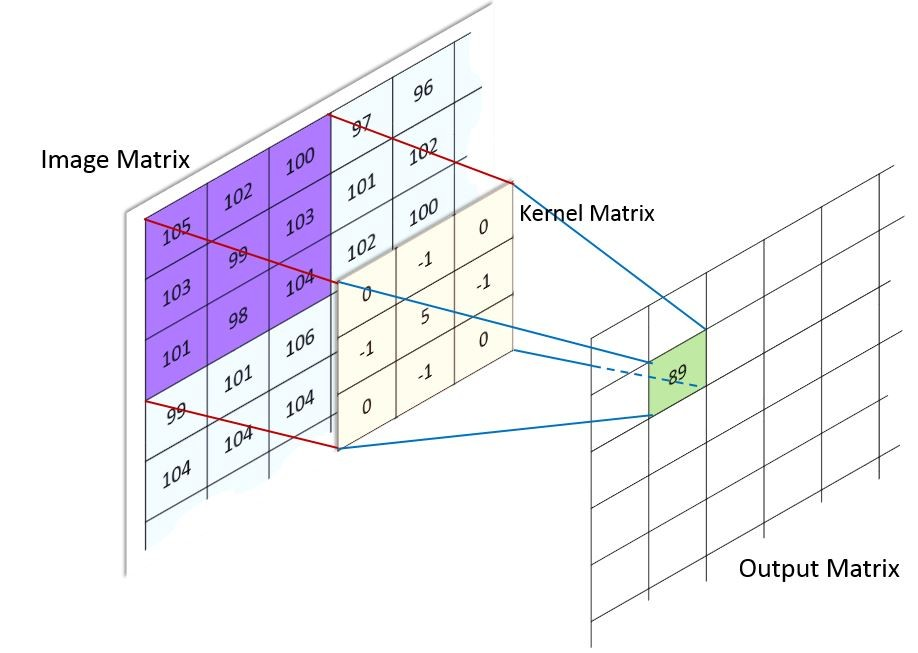

[source](https://www.linkedin.com/pulse/image-processing-convolution-filters-calculation-gradients-yadav)

In [ ]:
# we will define a convenient helper function for plotting before-after images

def plot_comparison(original, modified, modified_title=None):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(original, cmap='gray'); ax1.set_title('Original')
    ax2.imshow(modified, cmap='gray'); ax2.set_title(modified_title)
    plt.show()

In [ ]:
# Apply filters
from skimage import filters

image_frame = image[0, :, :]

# Apply a Gaussian filter to nuclei. 
# 'sigma' controls the amount of smoothing
blurred_image = filters.gaussian(image_frame, sigma=2.0)

plot_comparison(image_frame, blurred_image, "After Gaussian Blur")


In [ ]:
# Apply rank filters

# Apply a Median filter to nuclei. 
median_filtered_image = filters.rank.median(image_frame)

plot_comparison(image_frame, median_filtered_image, "Median filter")

#### Segmentation

Segmentation separates the image into meaningful regions (e.g., cells, nuclei, mitochondria). 

Examples:
- **Thresholding**: Converts grayscale images to binary masks. 
    - Pixels above a threshold are considered “foreground.” 
    - Thresholds can be manually chosen or computed automatically (e.g., Otsu’s method).
- **Edge detection**: Finds boundaries of objects based on intensity gradients.
- **Watershed**: Separates touching objects using topographic interpretation of intensity as landscapes.

In [ ]:
# Segmentation 

# Use Otsu's method to find the optimal threshold value.
otsu_threshold = filters.threshold_otsu(image_frame)
print(f"The automatically determined Otsu threshold is: {otsu_threshold}")

# Apply the threshold to create the binary mask.
mask = image_frame > otsu_threshold

plot_comparison(image_frame, mask, "Otsu's Threshold Applied")

In [ ]:
# Use filtered image as input 

otsu_threshold = filters.threshold_otsu(blurred_image)
mask = blurred_image > otsu_threshold

plot_comparison(blurred_image, mask, "Otsu's Threshold Applied")

#### Post-processing

After segmentation, binary masks often require refinements to improve object shapes and remove artifacts.

Morphological operations on binary masks:
- *Erosion*: Shrinks objects
- *Dilation*: Expands objects
- *Opening* (erosion → dilation)
- *Closing* (dilation → erosion)

In [ ]:
# Morphological Operations
from scipy import ndimage as ndi
from skimage import morphology

mask_filled = ndi.binary_fill_holes(mask) # Fill holes 
mask_opened = morphology.opening(mask_filled, morphology.disk(3)) #opening 
mask_cleaned = morphology.remove_small_objects(mask_opened, min_size=100) # Remove small objects (noise)

In [ ]:
plot_comparison(mask, mask_cleaned, 'cleaned mask')

In [ ]:
# Connected components labeling ~ instance segmentation
from skimage import measure

labels = measure.label(mask_cleaned)

print(f"Found {labels.max()} objects after cleaning and labeling.")

plot_comparison(mask_cleaned, labels, 'Labels')

##### Watershed 

Watershed algorithm is a method for separating connected or touching objects in a binary mask. 

It treats the image as a topographic surface, where bright regions are “peaks” and dark regions are “valleys.” The algorithm “floods” the valleys starting from predefined markers until regions meet, creating boundaries between objects.

On binary masks:
- We first compute the distance transform, where object centers have higher values.
- These centers are considered peaks, which are then used as markers.
- The watershed is applied on the negative distance map so that the peaks become valleys for flooding.

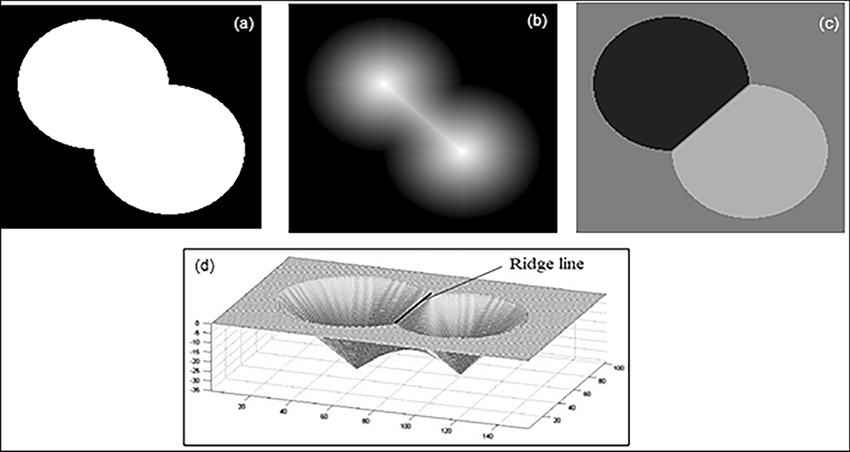

[source](https://www.researchgate.net/figure/Schematic-diagram-of-image-segmentation-with-the-watershed-algorithm-Source-Rabbani-et_fig4_377269538)

In [ ]:
# Watershed
from skimage import segmentation
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

distance = ndi.distance_transform_edt(mask_cleaned)
coords = peak_local_max(distance, min_distance=20, labels=mask_cleaned)

markers = np.zeros_like(distance, dtype=int)
for i in range(len(coords)):
    markers[coords[i, 0], coords[i, 1]] = i + 1

# Watershed
labels_watershed = segmentation.watershed(-distance, markers, mask=mask_cleaned)

plot_comparison(labels, labels_watershed, 'Watershed')

In [ ]:
# Lets visualize the steps as a stack
markers = morphology.dilation(markers)>0
steps = [mask_cleaned, distance, markers, labels_watershed]
processing_stack = np.stack(steps, axis = 0)

stackview.slice(processing_stack)

In [ ]:
# Plot as overlay
# multiple options (napari, matplotlib with alpha, sepcialized packages - label2rgb or stackview)
stackview.blend(image_frame, labels_watershed)

### Summary of our Workflow
We've just completed a full, basic image processing pipeline:
1. **Loaded** an image.
2. **Pre-processed** it by applying a Gaussian blur to reduce noise.
3. **Segmented** the nuclei class from the background by applying an automatic Otsu threshold.
4. **Refined** the resulting mask by using post-processing steps such as morphological operations.
5. Distinguised individual objects in binary mask with **connected components labeling**

Now is time for exercise.

##### --- ***Exercise*** ---

Perform the following steps to build a workflow to process an image.

1. Load the image from the assigned `image_path` variable.
2. Inspect it's properties.
    - find out the dimensions, size and data type of pixel values
    - optionally, inspect metadata if it exists
3. Show image in notebook (stackview or matplotlib)
4. Extract the mitochondrial channel (2nd)
5. The image is a bit noisy with high background. 
    - Apply a Gaussian filter - try different sigma values.
    - optionally, remove background using skimage.restoration.rolling_ball - 
        *Hint:* you need to first import it.
        The output is a background image, not background subtracted image.
6. Plot histogram of blurred/corrected image.
7. Compute automatic thresholds using Otsu and Mean methods.
8. Segment the image using both threshold methods and choose the best one.
    - Use `plot_comparison()` to show the two binary masks side by side.
9. Improve segmentation (optional)
    - Apply morphological operations to clean the mask (skimage.morphology)
10. Perform instance segmentation to get labels
11. Visualize the results
    - Show the labeled objects over the original mitochondrial channel (e.g., using stackview.blend)

In [ ]:
image_path = '../data/BPAE.tif'

# Your code here


<details>
<summary>Click to see the example solution</summary>

```python
from skimage import restoration

# 1. Load image
img = iio.imread(image_path)

# 2. Inspect properties
print(img.shape, img.size, img.dtype)

img_metadata = iio.immeta(image_path)
print(img_metadata)

# 3. Visualize
stackview.slice(img)
plt.show()

# 4. Extract mitochondrial channel
mito = img[1,:,:]

# 5. Denoise / background removal
i = filters.gaussian(mito, sigma=2)
i = i - restoration.rolling_ball(i, radius=15)
i = i.astype(np.uint16)

plt.imshow(i, cmap='gray')
plt.show()

# 6. Histogram
plt.hist(i.ravel(), bins=50)
plt.yscale('log')
plt.show()

# 7. Automatic thresholds
otsu_thr = filters.threshold_otsu(i)
mean_thr = filters.threshold_mean(i)
print(otsu_thr, mean_thr)

# 8. Segment
mask_otsu = i > otsu_thr
mask_mean = i > mean_thr

plot_comparison(mask_otsu, mask_mean)

# 9. Morphological cleaning (optional)

# 10. Instance segmentation
labels = morphology.label(mask_otsu)

# 11. Visualization
stackview.blend(mito, labels)
````

<br><br>

#### Operations between masks

In image analysis, it is often useful to combine or compare different binary masks to extract specific regions of interest. 

Masks as boolean arrays (True for foreground, False for background), can be processed with logical operations to create new masks.

Common operations:
- *Inversion - NOT (`~`)* – flips all boolean values:
    ```python
    inverted_mask = ~mask
    ```
- *Intersection (`&`)* – keeps only pixels present in both masks:
    ```python
    overlap_mask = mask1 & mask2
    ```
- *Union (`|`)* – includes all pixels present in either mask:
    ```python
    combined_mask = mask1 | mask2
    ```
- *Difference / Subtraction (`& ~`)* – removes pixels of one mask from another:
    ```python
    cytoplasm_mask = cell_mask & ~nuclei_mask
    ```
- *Exclusive OR (`^`)* – pixels present in one mask or the other, but not both:
    ```python
    xor_mask = mask1 ^ mask2
    ```

In [ ]:
# Tilde operator
mask = np.array([True, False, True])
inverted_mask = ~mask
inverted_mask

In [ ]:
# Use case

cell_mask = iio.imread('../data/BPAE_actin_mask.tif')
background_mask = ~cell_mask

plot_comparison(cell_mask, background_mask, 'background')

**Example Use Case:**

You have a cell_mask, a nuclei_mask, and a mitochondria_mask. 

If you want to extract the cytoplasm region, you can subtract the nucleus and mitochondria regions from the whole cell mask.

In [ ]:
# Read segmentation of mitochondria
mito_labels = iio.imread('../data/BPAE_mito_lbl.tif')
mito_binary = (mito_labels > 1) # convert to boolean array

plot_comparison(mito_labels, mito_binary, 'binary')

# Read nuclei masks
nuclei_mask = iio.imread('../data/BPAE_nuclei_mask.tif')

cytoplasm_mask = cell_mask & ~nuclei_mask & ~mito_binary

plot_comparison(cell_mask, cytoplasm_mask, '"cytoplasm"')


---
---

### Lesson 3: Measurements

The `measure.regionprops_table()` function from scikit-image computes quantitative features for each labeled region in an image.  

Each connected region (identified by a unique label) can be characterized by geometric and intensity-based properties.

The output of this function is a is a dictionary containing one array per measured property.

In [ ]:
# Measurements
 
# We specify which properties we want to measure for each object.
properties_to_measure = ('label', 'area', 'mean_intensity', 'perimeter', 'eccentricity')

# regionprops_table uses our `labels` image and the original `nuclei_image`
props_dict = measure.regionprops_table(
    labels_watershed,
    intensity_image=image_frame,
    properties=properties_to_measure
)

props_dict

In [ ]:
# Convert the dictionary of results into a Pandas DataFrame
import pandas as pd

image_df = pd.DataFrame(props_dict)

image_df.head(5) # show first 5 rows of a table

#### DataFrames (Pandas package)

Pandas is a library used for data manipulation and analysis, particularly useful for dealing with structured data like tables. It provides the tools to create and work with DataFrames.

DataFrame is a two-dimensional data structure similar to a spreadsheet (table).

We typically import pandas like this:
```python
import pandas as pd

```

In [ ]:
# You can create a DataFrame from different types of data.  

# Create a DataFrame from a dictionary of lists
import pandas as pd

measurement_data = {
    'cell_id': [1, 2, 3, 4],
    'area': [150, 230, 95, 180],
    'intensity': [88.5, 95.2, 101.0, 89.7]
}

df = pd.DataFrame(measurement_data)

# Display the DataFrame
df

In [ ]:
# We can easily get statistics from our data with .describe()
print("\n--- Summary Statistics ---")
print(df.describe())

In [ ]:
# You can extract a single column from a pandas DataFrame using its column name

# pandas Series 
# it keeps the row index and behaves like a labeled one-dimensional array.
area_column = df['area']
print(area_column) 
print(type(area_column))

print()

# without the index or Series structure 
area_values = df['area'].values
print(area_values)


In [ ]:
# You can filter data based on conditions

# This creates a new DataFrame containing only cells with area less than 200.
filtered_df = df[df['area'] < 200]
filtered_df

In [ ]:
# Combining multiple logical conditions
# Each condition must be in parentheses ( )
filtered_df2 = df[(df['area'] < 200) & (df['area'] > 150)]
filtered_df2


In [ ]:
# You can sort dataframes by one or more columns.
# ascending=True/False controls ascending/descending order

sorted_df = df.sort_values(by='intensity', ascending=False)
sorted_df

##### --- ***Exercise*** ---

You have experimental data in a dictionary. Your task is to analyze it with Pandas.
1. Create a **Pandas DataFrame** from the given data dictionary.
2. Filter the DataFrame to find all rows where the **Treatment** was `'Drug_A'`. 
  *Hint: use the equality operator `==`*
3. From the filtered data, compute the **average Score** for Drug A.
   *Hint: you can use .mean() on extracted 'Score' column*
4. Using the entire DataFrame, find out **which treatments were effective**.  
   *Hint: you can use .unique() on pandas Series object (extracted Treatment) to find unique treatments*
5. Display the **3 rows with the highest Score**.  
   *Hint: use `.sort_values('Score', ascending=False).head(3)`*

In [ ]:
## cd
data = {'Animal_id': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110],
        'Treatment': ['Drug_A', 'Drug_B', 'Placebo', 'Drug_A', 'Drug_B', 'Placebo', 'Drug_A', 'Drug_B', 'Drug_A', 'Drug_B'],
        'Result': ['Effective', 'Not Effective', 'Not Effective', 'Effective', 'Effective', 'Not Effective', 'Effective', 'Effective', 'Effective', 'Not Effective'],
        'Score': [50.3, 3.5, 10.1, 17.0, 93.3, 1.5, 99.9, 73.7, 69.2, 0.5]}


# Your code here

<details>
<summary>Click to see the example solution</summary>

```python
# 1. Create DataFrame from dictionary
df = pd.DataFrame(data)

# 2. Filter rows where Treatment is 'Drug_A'
drug_a_df = df[df['Treatment'] == 'Drug_A']
print("Rows with Drug_A treatment:")
print(drug_a_df)

# 3. Average Score for Drug_A
avg_score_drug_a = drug_a_df['Score'].mean()
print("\nAverage Score for Drug_A:", avg_score_drug_a)

# 4. Which treatments were effective?
effective_treatments = df[df['Result'] == 'Effective']['Treatment'].unique()
print("\nTreatments with at least one effective result:", effective_treatments)

# 5. Display 3 rows with the highest 'Score'
top3_scores = df.sort_values('Score', ascending=False).head(3)
print("\nTop 3 rows by Score:")
print(top3_scores)
```


<br><br>

Let's get back to our object measurements from image.

We ended by converting dictionary of measured properties to a pandas DataFrame.

In [ ]:
# Measurements analysis

# We can save our DataFrame as table (csv, excel, ...)
image_df.to_csv('../outputs/first_measurements.csv', index=False)

# We can read tables from file into DataFrames
loaded_df = pd.read_csv('../outputs/first_measurements.csv') # check other file formats
loaded_df.head(7)

In [ ]:
# DataFrames are convenient for plotting

plt.figure(figsize=(4, 4))
plt.hist(loaded_df['area'], bins=10)
plt.title('histogram')
plt.show()

plt.scatter(loaded_df['area'], loaded_df['mean_intensity'])
plt.title('scatterplot')
plt.xlabel('Area')
plt.ylabel('Mean intensity')
plt.show()

Aggregation

When we have multiple DataFrames, we can combine them into single one.

In [ ]:
# Aggregation (multiple tables)

df_image1 = pd.read_csv("../data/cells_control.csv")
df_image2 = pd.read_csv("../data/cells_diseased.csv")
df_image3 = pd.read_csv("../data/cells_conditioned.csv")

# Merge dataframes
combined_df = pd.concat([df_image1, df_image2, df_image3], ignore_index=True)

combined_df

##### DataFrame data types

Not all columns have to store numerical data.

Data types can be:
- int64, float64 → numeric columns
- object → usually strings (categories, text)
- category → categorical data (memory-efficient, useful for grouping)


You can quickly check the data types of each column using:
```python
print(df.dtypes)   # Shows the type of each column
print(df.info())   # Shows summary including data types and non-null counts
```

You can convert string/object columns to categorical with method: `.astype("category")`

In [ ]:
print(combined_df.info())

In [ ]:
combined_df["Group"] = combined_df["Group"].astype("category")
combined_df["State"] = combined_df["State"].astype("category")

print(combined_df.dtypes)

##### Group-level statistics

When your dataset has **categorical variables** (like experimental groups, treatments, or conditions) and **numeric measurements**, it is often useful to calculate statistics **per group**.

- `describe()` can give summary statistics for the **entire DataFrame**, but it does not separate by category:
- to get statistics per group, you can use `groupby()` combined with `agg()` (aggregate)

In [ ]:
# describe method is applied on entire dataframe without disciminating categories
combined_df.describe()

In [ ]:
# if we want to extract statistics per group, we can use methods group_by() and agg()

# !! agg() works only on numerical columns
# we need to remove all other types first (except the ones for grouping)
reduced_df = combined_df.drop("State", axis=1) 

summary_per_group = reduced_df.groupby('Group').agg(["count", "mean", "std"]) 
summary_per_group

In [ ]:
# we can address multiple factors
summary_per_group_and_state = combined_df.groupby(['Group','State'], observed=False).agg(["count","sum", "mean", "std"]) 
summary_per_group_and_state

##### Visualizing group differences with Seaborn

The **Seaborn** library builds on Matplotlib but provides higher-level plotting functions tailored for statistical data.

A particularly useful feature is the `hue` argument, which colors data points by group/category.

In [ ]:
# Seaborn 
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=combined_df, 
    x="Group", 
    y="Mean_Intensity", 
    hue="Group", 
    palette="Set2"
    )

plt.show()

In [ ]:
# Some seaborn plots also allow discrimination of multiple factors
  
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=combined_df, 
    x="Area", y="Circularity", 
    hue="Group", style='State'
    )
plt.show()

#### Hypothesis Testing

Visualizations help us see patterns and differences in data, but they are not enough for statistical confirmation.  
To formally test whether groups differ, we use hypothesis testing.

In Python, the `scipy.stats` module provides a variety of statistical tests.

Below, we will use a **t-test** to compare whether the **means of two groups are equal**:

In [ ]:
# Hypothesis testing

from scipy.stats import ttest_ind

# the following is combination of filtering DataFrame and extracting column Mean_Intensity
controls = combined_df[combined_df['Group']=='Control']['Mean_Intensity']
diseased = combined_df[combined_df['Group']=='Diseased']['Mean_Intensity']

# the t-test takes two lists/arrays 
# by default the ttest_ind() performs two-sided t-test and assumes independent samples
t_stat, p_value = ttest_ind(controls, diseased)

print(f"\nT-test p-value for comparing areas: {p_value:.9f}")


##### --- ***Exercise*** ---


On `combined_df` from previous exercises perform the following:

1. Compute mean and standard deviation of all numerical columns per factor **State**. 
    - Which cells have the largest average area?
2. Make a boxplot comparing **Area** across categories of **State**.
4. Add a swarmplot (`sns.swarmplot`) on top of boxplot to see individual datapoints.
5. Perform a t-test comparing "Circularity" between Control and Diseased.
6. Perform a t-test comparing "Mean_Intensity" between Starved Pre-conditioned and Unstarved Pre-conditioned.

In [ ]:
# Your code here


<details>
<summary>Click to see the example solution</summary>

```python
# Compute mean and std per State
r_df = combined_df.drop('Group', axis=1)
summary_state = r_df.groupby("State", observed=False).agg(["mean", "std"]).round(2) # optional rounding
print(summary_state)

# Boxplot with swarmplot for Area per State
plt.figure(figsize=(6, 4))
sns.boxplot(data=combined_df, x="State", y="Area", palette="Set2", hue='State')
sns.swarmplot(data=combined_df, x="State", y="Area", color='black')
plt.tight_layout()
plt.show()

# T-test Circularity: Control vs Diseased
controls = combined_df[combined_df["Group"] == "Control"]["Circularity"]
diseased = combined_df[combined_df["Group"] == "Diseased"]["Circularity"]
t_stat, p_value = ttest_ind(controls, diseased)
print(f"T-test Circularity (Control vs Diseased): p = {p_value:.4f}")

# T-test Mean_Intensity: Starved vs Unstarved Pre-conditioned
pre_starved = combined_df[
    (combined_df["Group"] == "Pre-conditioned") & (combined_df["State"] == "Starved")
]["Mean_Intensity"]
pre_unstarved = combined_df[
    (combined_df["Group"] == "Pre-conditioned") & (combined_df["State"] == "Unstarved")
]["Mean_Intensity"]
t_stat, p_value = ttest_ind(pre_starved, pre_unstarved)
print(f"T-test Mean_Intensity (Starved vs Unstarved, Pre-conditioned): p = {p_value:.4f}")
```


---
---

### Lesson 4: Automation

In the previous Lesson, we practiced designing and tuning a full image-processing workflow:
- We loaded and visualized microscopy images.
- We adjusted individual processing steps such as filtering, thresholding, and segmentation.
- We extracted quantitative measurements (e.g., area, intensity, circularity).
- Finally, we analyzed those measurements using **Pandas**, **Seaborn**, and **scipy** packages.

That workflow worked — but it was **manual**.  
Each change in parameters required editing the code and re-running it, which is inefficient when you want to test multiple settings or process multiple images.

Now we’ll make our work **smarter and faster** by introducing two types of automation:

1. **Parameter Sweep:**  
   Applying *different settings* (e.g., filter size, threshold method) to the **same image**, so we can compare their effects.

2. **Batch Processing:**  
   Applying *final workflow* to **many images**, so we can process entire datasets automatically.


---
##### Parameter Sweep Example

Let’s compare how different levels of Gaussian blur affect the same image.

- We define a list of parameter values (sigma_values) to test.
- We use a simple **loop** to apply the same function with each parameter.
- We use another **loop** to plot images with subplots

In [ ]:
# Load one image
input_image = iio.imread('../data/noisy_cells.tif')

# Define sigma values for Gaussian blur
sigma_values = [1, 3, 5, 7, 9, 11]

# Apply Gaussian filter with different sigmas
blurred_images = []
for sigma in sigma_values:
    blurred = filters.gaussian(input_image, sigma=sigma)
    blurred_images.append(blurred)

# Alternative: list comprehension
# blurred_images = [filters.gaussian(image, sigma=s) for s in sigma_values]

# Plot results side by side
fig, axes = plt.subplots(1, len(sigma_values), figsize=(25, 5))

# zip() is a built-in Python function 
# it lets you iterate over multiple sequences (lists, tuples...) in parallel
for ax, s, img in zip(axes, sigma_values, blurred_images):
    ax.imshow(img, cmap="gray")
    ax.set_title(f"σ = {s}")
    ax.axis("off")

plt.suptitle("Effect of Gaussian Blur with Different σ", fontsize=16)
plt.show()
 

##### --- ***Exercise*** ---

Test how different thresholding algorithms segment the same image.

- Use the image from previous exercise (input_image).
- Create a dictionary of thresholding methods (Otsu, Li, Yen, Minimum).
    - such as `dict = {'name1': function1(), 'name2': function2()}`
- Create a new empty dictionary to store results.
- Use a loop to iterate over the methods in dictionary (*Hint: loop through the dictionary items using `for key, value in methods.items()`)
    - apply thresholding method to get threshold value
    - generate a binary mask with threshold value
    - store binary array in the new dictionary under the method name (*Hint: store value under key with `new_dictionary[key]=value`*)
- Optional: Plot binary arrays in one figure. (*Hint: you can iterate over axis and dict items together with `for ax, (key, value) in zip(axes, dict.items()`*)
    - Optional: Plot the original image alongside binary arrays in one figure.

In [ ]:
# Your code here


<details>
<summary>Click to see the example solution</summary>

```python
from skimage.filters import threshold_otsu, threshold_li, threshold_yen, threshold_minimum

# Dictionary of thresholding methods
methods = {
    "Otsu": threshold_otsu,
    "Li": threshold_li,
    "Yen": threshold_yen,
    "Min": threshold_minimum
}

# Create empty dictionary to store masks
masks = {}

# Apply each thresholding method in a loop
for name, func in methods.items():
    thresh = func(input_image)        
    mask = input_image > thresh      
    masks[name] = mask          

# Add original image to the new dictionary to make plotting easier
masks['raw'] = input_image

# Plot original image + threshold results
fig, axes = plt.subplots(1, len(masks), figsize=(16, 5))

for ax, (name, mask) in zip(axes, masks.items()):
    ax.imshow(mask, cmap="gray")
    ax.set_title(name)
    ax.axis("off")

plt.show()
```

<br><br>

In [ ]:
# By the way, skimage has a function to try all thresholds

filters.try_all_threshold(input_image, figsize=(8, 5), verbose=False)
plt.tight_layout()


---

##### Automated workflow


Now, we will apply a complete workflow automatically, from image → segmentation → measurements → results table.

We will simply take the individual steps and package them into a function.


In [ ]:
# Build full workflow - from image to table

def analyze_slice(image_array, slice_index = 0):
    filtered_array = filters.gaussian(image_array, 3)
    threshold_value = filters.threshold_otsu(filtered_array)
    mask = filtered_array > threshold_value
    processed_mask = ndi.binary_fill_holes(mask)
    mask_cleaned = morphology.remove_small_objects(processed_mask, min_size=100) 
    label_image = measure.label(mask_cleaned)
    props_dict = measure.regionprops_table(label_image, intensity_image=image_array,
                                           properties=('label', 'area', 'mean_intensity'))
    
    results_df = pd.DataFrame(props_dict)
    # Add the source filename to track our data
    results_df['slice'] = slice_index
    return results_df, label_image


In [ ]:
# We will run our function on single slice and validate results

image_3d = iio.imread('../data/nuclei_stack1.tif')

print(image_3d.shape)

In [ ]:
input_slice = image_3d[10,:,:]

my_results, my_label = analyze_slice(input_slice, 10)

my_results.head()

In [ ]:
plt.imshow(my_label)

In [ ]:
# Now we can use our function in a loop to easily process all slices

# get number of slices in our image
n_slices = image_3d.shape[0]

# initialize empty variables for storage of outputs
new_df = pd.DataFrame()
labels = []

# run loop
for index in range(n_slices):
    # Print progress
    print('Processing slice:', index)

    # Analyze one slice
    result_df, result_labels = analyze_slice(image_3d[index], index)
    
    # Append results to DataFrame
    new_df = pd.concat([new_df, result_df], ignore_index=True)
    
    # Store labels for visualization or later use
    labels.append(result_labels)

print('Finished!')

In [ ]:
# Show DataFrame
new_df

In [ ]:
# View stack of labels
labels_stack = np.stack(labels)
stackview.slice(labels_stack)

##### --- ***Exercise*** --- 

**Create an Analysis Function** - Follow the steps below to build a new function. 

**Instructions:**
1. Define a function called `analyze_nuclei`.
2. This function should take two arguments: `image_array` (the image to process) and `source` (a string with file name).
3. Inside the function, perform the entire pipeline defined below (blur, threshold, clean, label).
4. After labeling, use `measure.regionprops_table` to calculate the `'label'`, `'area'`, and `'mean_intensity'` for each nucleus. Remember to use the original `image_array` for the `intensity_image`.
5. Convert the resulting dictionary to a Pandas DataFrame.
6. Add a new column to the DataFrame called `'filename'` and set its value to the `source` argument.
7. The function should `return` this final DataFrame and labels.
8. Test your function by calling it with the provided image and filename. 
9. Print the head of the resulting DataFrame and show resulting segmentation to check that it works.

```python
# processing pipeline
filtered_image = filters.gaussian(image, 1)
threshold_value = filters.threshold_otsu(filtered_image)
mask = filtered_image > threshold_value
processed_mask = ndi.binary_fill_holes(mask)
mask_cleaned = morphology.remove_small_objects(processed_mask, min_size=50) 
label_image = measure.label(mask_cleaned)
```


In [ ]:
test_image = iio.imread('../data/batch_analysis/i0.tif')

# Your code here


<details>
<summary>Click to see the example solution</summary>

```python
# Create function
def analyze_nuclei(image_array, source):
    filtered_array = filters.gaussian(image_array, sigma=1)
    threshold_value = filters.threshold_otsu(filtered_array)
    mask = filtered_array > threshold_value
    processed_mask = ndi.binary_fill_holes(mask)
    mask_cleaned = morphology.remove_small_objects(processed_mask, min_size=50)
    label_image = measure.label(mask_cleaned)

    props = measure.regionprops_table(label_image, intensity_image=image_array,
                                      properties=['label', 'area', 'mean_intensity'])
    df = pd.DataFrame(props)

    df['filename'] = source

    return df, label_image


# Call the analysis function
results_df, labels = analyze_nuclei(test_image, source='i0.tif')

# Show first rows of results
print(results_df.head())

# Show segmentation
plt.figure(figsize=(6,6))
plt.imshow(labels, cmap='nipy_spectral')
plt.title("Labeled Nuclei")
plt.axis('off')
plt.show()

# Optional: blend with original image using stackview
stackview.blend(test_image, labels)
```

<br><br>
#### A Quick Guide to File Paths

Packages: `os`, `glob`, and `pathlib`

In [ ]:
# --- os.path.join(): The safe way to build paths ---
import os
# This automatically uses the correct separator for your OS (`/` or `\`)
folder = "data"
filename = "image_01.tif"
# This is the RIGHT way to do it:
correct_path = os.path.join(folder, "subfolder", filename)
print(f"OS-safe path: {correct_path}")


# Get directory and filename parts
directory = os.path.dirname(correct_path)
base_name = os.path.basename(correct_path)

print(f"Directory part: {directory}")
print(f"File name part: {base_name}")

In [ ]:
# --- os.makedirs(): Create directories safely ---
# Create the directory if it doesn’t exist yet
os.makedirs('test_folder', exist_ok=True)

In [ ]:
# --- glob.glob(): The way to find files with wildcards ---
import glob

# Find all files ending with .tif
tif_files = glob.glob(os.path.join("../data", "*.tif"))
print(f"\nFound TIF files: {tif_files}")

In [ ]:
# --- pathlib  ---
from pathlib import Path

# It uses objects and the `/` operator, which is very clean.
p = Path("data")
csv_file_path = '..' / p / "cells_control.csv"
print(f"\nPathlib object: {csv_file_path}")
print(f"Does this file exist? {csv_file_path.exists()}")


# --- Get parts of the path ---
print(f"Parent folder: {csv_file_path.parent}")
print(f"Filename only: {csv_file_path.name}")

#### Process all images in folder

In [ ]:
# let's combine our previous exercises together
# use for-loop to apply function on all images in folder 

# Step 1: Define our final, reusable analysis function (using Otsu)
def analyze_image_final(image_array, source_filename):
    blurred_image = filters.gaussian(image_array, 3)
    threshold_value = filters.threshold_otsu(blurred_image)
    mask = blurred_image > threshold_value
    label_image = measure.label(mask)
    props_dict = measure.regionprops_table(label_image, intensity_image=image_array,
                                           properties=('label', 'area', 'mean_intensity'))
    results_df = pd.DataFrame(props_dict)
    # Add the source filename to track our data
    results_df['source_file'] = source_filename

    return results_df

# Step 2: Find the files
input_folder = "../data/batch_analysis/input"
file_list = glob.glob(os.path.join(input_folder, "*.png"))

# Step 3: Loop and aggregate results
all_image_results = []
print("\nStarting batch processing...")

for file_path in file_list:
    print(f"Processing: {file_path}")
    image = iio.imread(file_path)
    # Get just the filename from the full path for cleaner tables
    filename_only = os.path.basename(file_path)
    
    single_image_df = analyze_image_final(image, filename_only)
    all_image_results.append(single_image_df)
    
# Step 4: Concatenate into a final DataFrame
final_batch_df = pd.concat(all_image_results, ignore_index=True)

print("\n--- Final Batch Results ---")
final_batch_df

##### --- ***Exercise*** --- 

***Batch Process the Entire Dataset***

You have the tools, you have the function. Now it's time to automate everything!

**Instructions:**
1. Use `glob` to get a list of all `.tif` files in the `batch_analysis/nuclei_data` folder.
2. Create an empty list called `all_nuclei_results`.
3. Write a `for` loop that iterates through your list of file paths.
4. Inside the loop:
    - Load the current image using `iio.imread()`.
    - Get just the filename (without the folder path) using `os.path.basename()`.
    - Call your `analyze_nuclei` function with the loaded image and the filename.
    - Append the DataFrame returned by the function to your `all_nuclei_results` list.
5. After the loop, use `pd.concat()` to combine the list of DataFrames into a single, master DataFrame.
6. Print the head and tail of your final DataFrame to see the combined results from all images.
7. As a final analysis, create a boxplot showing the distribution of nuclei `area` for each of the source images.
    - *Hint*: `seaborn.boxplot` is great for this, you can use `source` column as `hue` argument.

In [ ]:
# Your code here


<details>
<summary>Click to see the example solution</summary>

```python
# 1. Get list of all .tif files in the folder
image_files = glob.glob("../data/batch_analysis/nuclei_data/*.tif")

# 2. Create an empty list to store results
all_nuclei_results = []

# 3. Loop through each file
for file_path in image_files:
    # Load image
    image_array = iio.imread(file_path)
    
    # Extract filename only
    filename = os.path.basename(file_path)
    
    # Analyze nuclei
    df, labels = analyze_nuclei(image_array, filename)
    
    # Append results to list
    all_nuclei_results.append(df)

# 5. Combine all DataFrames into a single master DataFrame
master_df = pd.concat(all_nuclei_results, ignore_index=True)

# 6. Inspect results
print(master_df.head())
print(master_df.tail())

# 7. Boxplot of nuclei area per image
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_df, x='filename', y='area', palette="Set3", hue='filename')
plt.xticks(rotation=45)
plt.ylabel("Nuclei Area")
plt.xlabel("Source Image")
plt.tight_layout()
plt.show()
```

<br><br>
#### Slice-by slice reading

When working with image data stored as a series of files, it is often useful to load all slices into a single multi-dimensional array for easier processing.

The **scikit-image** function `imread_collection()` allows you to read multiple images at once using a filename pattern.
You can use a wildcard (*) to match all files in a folder that belong to your dataset. This collection can then be converted into a **NumPy** array, effectively creating an image stack.

However, the number of z-slices, channels or frames is not recognized. You have to reshape the loaded data into the appropriate multi-dimensional form (for example, (z, c, y, x)) your self.

*Note*: Alternatively, you can build your own for-loops to load images from disk manually.
This approach gives you more flexibility — for example, to sort slices and channels, skip specific files, or arrange the data into custom dimensions.

In [ ]:
from skimage import io

im_collection = io.imread_collection('../data/batch_analysis/tiffs/' + "*")
image_stack = im_collection.concatenate()
image_stack.shape

In [ ]:
# Change the shape of array with reshape

num_channels = 2
num_z_slices = 5
num_t_frames = 10
image5d = np.reshape(image_stack, (num_t_frames, num_z_slices, num_channels, image_stack.shape[-2], image_stack.shape[-1]))
image5d.shape

In [ ]:
stackview.slice(image5d)